# A tutorial for building Inverted Encoding Models (IEMs) on EEG data via Procrustes' transformation: An SSVEP study

Here I will apply two novel methodologies to fit an IEM to EEG data. The [data](https://osf.io/qx94k/?view_only=e256bebd6e7c4f888a696fb35919913d) come from a study [link](NA) where participants were presented two superimposed dot arrays each of which flickered at a distinct frequency (7.5 and 8.57 Hz). The dataframe is the amplitudes from a fast Fourier transform (FFT) procedure belonging to several participants.

![Stimulus and Conditions](./figures/stimulus_and_conditions.png)

On the left you can see an example stimulus display which consists of two dot arrays whose colors were sampled from a range on a color wheel (right). Participants were asked to attend one array and ignore the other (see [the manuscript](NA) for details of the task). In the narrow target condition, the target array's colors were sampled from a 20º range around 1 of 6 equidistant centers (see black arrows) on the colorwheel. The distractor array was always homogenous in color and 180º away from the target color center. In the broad target condition the only difference was that the target color range was 60º instead of 20º. Importantly, each array flickered at a distinct frequency, which modulated the visually responsive neurons responding to each array at the corresponding frequencies.

In this tutorial, we will handle EEG data from this experiment where we apply the IEMs on the SSVEP amplitudes associated with target and distractor arrays.

But first, we need to arrange the dataset such that we only have the peak amplitudes associated with the stimulation frequencies. Conventionally, SSVEPs associated with different frequencies are handled in separate analysis pipelines in IEM (see REF). In this tutorial, I will demonstrate a linear transformation –called the Procrustes' transformation, which will allow us to combine SSVEPs from different frequencies.

If you are new to IEMs, please refer to following tutorials, first:

1. [Matlab-based Tutorial from Gardner Lab](https://gru.stanford.edu/doku.php/tutorials/channel)
2. [Python-based Brainiak Tutorial](https://brainiak.org/examples/iem.html)

Without further a-do, let's start with examining the dataset:


In [1]:
import pandas as pd
import numpy as np

def process_fft_data(filepath, participant_id, dv="fft_amplitude"):
  """
  Processes FFT data from a CSV file to extract peak amplitudes for specific 
  stimulation frequencies and reshape the data for analysis.

  Args:
    filepath: Path to the CSV file containing the FFT data.
    participant_id: ID of the participant to extract data for.
    dv: Name of the column containing the dependent variable (amplitudes). 
        Defaults to "fft_amplitude".

  Returns:
    A pandas DataFrame with the processed data.
  """

  def find_local_max(df, n=1, stim_freqs=120/np.array((14,16)), dv='fft_amplitude'):
    """
    Extracts the peak amplitudes for a given set of frequencies within a DataFrame.

    Args:
      df: pandas DataFrame containing the FFT data.
      n: Number of neighboring data points to consider when finding the peak. 
         Defaults to 1.
      stim_freqs: Array of stimulation frequencies. Defaults to 120/np.array((14,16)).
      dv: Name of the column containing the dependent variable (amplitudes). 
          Defaults to "fft_amplitude".

    Returns:
      A pandas DataFrame with the extracted peak amplitudes and corresponding 
      search frequencies.
    """
    if n != 1: 
      raise ValueError("n has to be 1 for now.")

    idx = np.array([np.argmin(np.abs(df['frequency']-fqN)) + n*[-1,0, 1] for fqN in stim_freqs])
    peak_idx = np.array([idxN[np.argmax(df.iloc[idxN][dv])] for idxN in idx])
    
    # Prevents assigning the same amplitude to each frequency
    if len(np.unique(peak_idx)) == 1:
        if np.argmax(df.iloc[peak_idx + [-1,1]][dv]) == 0: 
          peak_idx[0] += 1
        else: 
          peak_idx[1] -= 1

    return(df.iloc[peak_idx].assign(search_frequency = stim_freqs))

  # Stimulation frequencies
  stim_freqs = np.around(120/np.array((14,16)), decimals=2)

  # Color centers (in radians)
  stimulated_color_centers = np.linspace(-180,180,7)[:-1]*np.pi/180

  # Load and process the data
  df = (
      pd.read_csv(filepath)
      .set_index('participant').loc[participant_id].reset_index()
      .groupby(['participant','trial','channels'])
      .apply(find_local_max, stim_freqs=stim_freqs, dv=dv)
  )

  df["search_frequency"] = np.around(df["search_frequency"], decimals=2)
  df[["conditions","target_frequency","color_center"]] = df['conditions'].str.split('/',expand=True)

  # Pivot the DataFrame
  df = pd.pivot_table(df.reset_index(drop=True), 
                    values=[dv],
                    columns=["channels"],
                    index=["participant","search_frequency","trial","conditions","target_frequency","color_center"]
                    ).reset_index()

  # Data cleaning and transformation
  df["target_frequency"] = df["target_frequency"].replace(
                     {"TargetFreq8":stim_freqs[0],"TargetFreq7":stim_freqs[1]}
                  )
  df["color_center"] = df["color_center"].replace({"Color{}".format(n):deg for n, deg in zip(range(6),stimulated_color_centers)})
  df["color_center"] = df["color_center"].where(df['search_frequency'] == df['target_frequency'], 
                                                other=((((df["color_center"] + np.pi) + np.pi) % (2 * np.pi)) - np.pi))
  df["color_center"] = np.around(df["color_center"],decimals=2)
  df['isTargetSNR'] = df['search_frequency'] == df['target_frequency']

  return df

stim_freqs = np.around(120/np.array((14,16)), decimals=2)
stimulated_color_centers = np.linspace(-180,180,7)[:-1]*np.pi/180
df = process_fft_data(filepath='./data/trial_fft_and_snrs_per_channel.csv', participant_id=[2])
df.head()

participant search_frequency trial conditions target_frequency  \
channels                                                                  
0                  2              7.5     0      Broad             7.50   
1                  2              7.5     1      Broad             7.50   
2                  2              7.5     2     Narrow             7.50   
3                  2              7.5     3     Narrow             8.57   
4                  2              7.5     4     Narrow             7.50   

         color_center fft_amplitude                                ...  \
channels                         C3        C4       CP1       CP2  ...   
0               -2.09      0.426401  0.501453  0.447053  0.422470  ...   
1                2.09      0.120311  0.261148  0.359663  0.311242  ...   
2                0.00      0.647754  0.885843  0.485173  0.500302  ...   
3                2.09      0.399796  0.279494  0.345658  0.284291  ...   
4                1.05      0.289175  0.629402  0.254022  0.254678  ...   

                                                                      \
channels        P7        P8       PO3       PO4       PO7       PO8   
0         0.823744  0.600451  0.755442  0.474742  0.756471  0.500486   
1         0.663558  0.754915  0.456461  0.556823  0.393715  0.587847   
2         0.736767  0.760496  0.836037  0.747806  0.803267  0.506949   
3         0.357475  0.852580  0.734258  0.439080  0.565342  0.758221   
4         0.836837  0.410077  0.891112  0.652233  0.659773  0.174253   

                                       isTargetSNR  
channels       POz        T7        T8              
0         0.810040  1.494564  0.726016        True  
1         0.514635  1.213947  0.950094        True  
2         0.610304  0.808937  1.043380        True  
3         0.650558  1.166618  1.147526       False  
4         0.631757  0.845762  1.081169        True  

[5 rows x 37 columns]

Current dataframe contains fft amplitudes per stimulation frequency (7.5 or 8.57 Hz) for every trial. In roughly the half of the trials one stimulation frequency represent the attended and the other the unattended. In the remaining half, reverse is true. Also, the color ranges of the target array were indicated under conditions as 'Broad' or 'Narrow'. Color centers indicate one of 6 equidistant color centers around a isoluminant colorwheel in radians.

Each stimulation frequency induces idiosyncratic steady-state evoked potentials (SSVEPs). This idiosyncracity is due to the differences in how neural populations respond to specific frequency. Next, we will minimize the differences due to stimulation frequencies, using Procrustes transformation (REF).

## Procrustes Transformation

Procrustes transformation is a set of linear transformation on a hyperspace such that the structure of a matrix A is made similar to matrix B on a hyperspace where each feature indicates a coordinate. Each row/observation in matrix A should match the conditions of interest in matrix B since we want corresponding rows to retain its latent structure so that the underlying experimental manipulations would not be affected by this transformation. Therefore, we need to split our dataframe per peak frequency and subsample and order it in a way that each corresponding row represent the same 'conditions', 'target_frequency', and ' color_center'.

In [2]:
from scipy.spatial import procrustes
from sklearn.preprocessing import StandardScaler

# This will create balanced samples per given condition level and apply procrustes transform across stimulation frequencies

def balance_and_align(df, conditions_to_balance, transform_by_column, isNormalize=False):
  """
  Balances the data by sampling equal number of trials per condition, 
  preprocesses the feature matrices, and aligns them using Procrustes analysis.

  Args:
    df: pandas DataFrame containing the data.
    conditions_to_balance: List of column names to group by for balancing.
    transform_by_column: Column name to use for transformation (e.g., 'trial').
    stim_freqs: Array of stimulation frequencies.

  Returns:
    A tuple containing two aligned numpy arrays, one for each stimulation 
    frequency.
  """

  def balance_sample(df, column):
    # Get the minimum number of trials across all groups
    min_samples = df[column].value_counts().min()
    # Sample the same number of trials per group
    return df.groupby(column).sample(n=min_samples, replace=False)

  # Balance the data
  df = (
      df.groupby(conditions_to_balance)
      .apply(lambda x: balance_sample(x, transform_by_column))
      .reset_index(level=conditions_to_balance, drop=True)
      .sort_values(by=['search_frequency','conditions', 'isTargetSNR','color_center','trial'])
  )

  # Split dataframes and normalize
  mat1, mat2 = [
      StandardScaler().fit_transform(df.loc[df["search_frequency"]==freqN, "fft_amplitude"].values)
      for freqN in stim_freqs
  ]

  # Apply Procrustes transformation
  mat1, mat2, _ = procrustes(mat1, mat2)
  if isNormalize: 
    mat1, mat2 = [StandardScaler().fit_transform(matN) 
                  for matN in [mat1, mat2]]

  return df, mat1, mat2

conditions_to_balance = ["conditions", "color_center", "isTargetSNR"]
transform_by_column = "search_frequency"

df, mat1, mat2 = balance_and_align(df, conditions_to_balance, transform_by_column)
    

Before we replace the feature matrix with the transformed matrix let's first see how the Procrustes transformation changed the data structure.

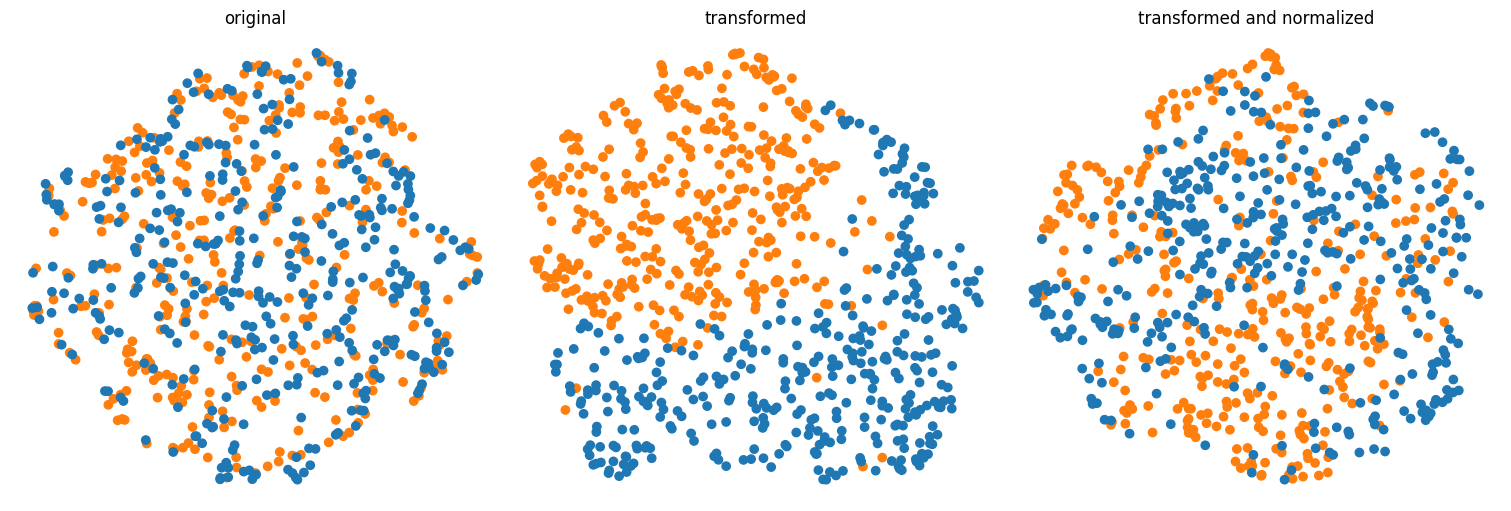

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from seaborn import color_palette

pca = PCA(n_components=.75, whiten=True)
reducer = umap.UMAP()
fig, ax = plt.subplots(1,3, layout="constrained", figsize=(15, 5))
plt.set_cmap("twilight")

old_pc = pca.fit_transform(df["fft_amplitude"].values)
old_embedding = reducer.fit_transform(old_pc)

new_pc = pca.fit_transform(np.vstack([mat1, mat2]))
new_embedding = reducer.fit_transform(new_pc)

new_pc_norm = pca.fit_transform(np.vstack([StandardScaler().fit_transform(matN) for matN in [mat1, mat2]]))
new_embedding_norm = reducer.fit_transform(new_pc_norm)

snr_fq = df.search_frequency.to_numpy()
xlabels = ["original", "transformed", "transformed and normalized"]

for whAx, embN in enumerate([old_embedding, new_embedding, new_embedding_norm]):
        ax[whAx].scatter(embN[:, 0], embN[:, 1],
            c = [color_palette()[np.int64(x==min(stim_freqs))] for _, x in enumerate(snr_fq)],           
            )
        ax[whAx].set_title(xlabels[whAx])
        ax[whAx].axis('off')

Above, each color represent a different frequency. You can see in the middle plot that the transformation clustered individual frequencies together. It is important to note that the Procrustes' transformation maximizes resemblance across matrices, of the internal structures within each matrix. You can observe this by the symmetrical nature of the clusters with respect to each other. 

This operation also pushed away each matrix in separate position in the feature space. However, this is not a problem for us since our model will not learn this information. We can also normalize the transformed matrices to make them overlap in the feature space (right).

Next we will change the feature values and move on with building our model.

In [4]:
# Store the transformed dataset
df_proc = df.copy()
df_proc["fft_amplitude"] = np.vstack(
    [StandardScaler().fit_transform(matN) for matN in [mat1, mat2]]
    )

## Building an ordinary IEM

An ordinary IEM procedure is established by reverting a *forward model* such that 
$$
B = W \ast C \tag{1}
$$
$B$ is the $k$-by-$n$ feature matrix where $n$ is the number of observations/trials and $k$ is the number of features/sensors. $C$ is the $m$-by-$n$ matrix the channel responses of hypothetical neural populations where $m$ is the number of channels. $W$ is the $k$-by-$m$ weight matrix that maps channel responses to sensors.

To invert the forward model, we first will split our dataset into testing and training datasets to find $W$ matrix such that
$$
\hat{W} = B_{train} \ast C^{T}_{train} \ast (C_{train} \ast C^{T}_{train})^{-1}\tag{2}
$$
where $\hat{W}$ is the predicted weight matrix, $(...)^{T}$ denotes the transpose operator on a matrix, and $(...)^{-1}$ denotes for the inverse operator on a matrix. 

An ordinary IEM pipeline then would entail using the $\hat{W}$ to solve for channel responses of the left out dataset such that
$$
\hat{C}_{test} = (\hat{W}^{T} \ast \hat{W})^{-1} \ast \hat{W}^{T} \ast B_{test}\tag{3}
$$

It is important to note that a true inverse for any of the matrices here do not exist due to multi collinearities across columns as well as the fact that these matrices are hardly ever square matrices. Because of this, in application we utilize approximations –that is, pseudo-inverses of matrices calculated through singular value decomposition and least squares estimation.

### Encoding/Forward model: creating hypothetical channels

For the hypothetical channels we can think of 6 channels whose preferences peak at one of each target color center. Response of a channel to a given color $\theta$ with preference for a given color center $\hat{\theta}_{i}$ would be a tuning function which could be likened by the following formula:
$$
C_{i}(\theta) =  ||cos^{7}(\frac{\theta - \hat{\theta}_{i}}{\Omega})||\tag{4}
$$
where $\Omega$ determines the width of the tuning function and $||...||$ denote for rectification such that $C_{i} = 0$ for all $C_{i}<0$.

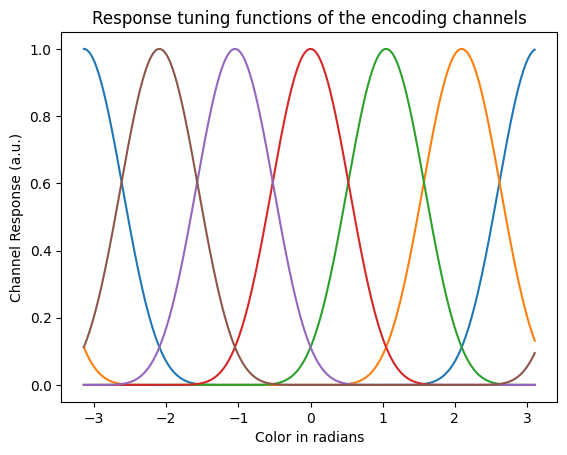

In [5]:
# Parameters
n_ch = 6
ch_width = 80*np.pi/180
exponent = 7

#equidistant centers for channels on a circular space from -pi to pi
ch_preference = np.linspace(-180,180,n_ch+1)[:-1]*np.pi/180
stimulus_space = np.arange(-np.pi, np.pi, np.pi/180)[:-1]
ch_center_idx = np.array([np.argmin(abs(stimulus_space - x)) for x in ch_preference])

halfrectcos = lambda center, width, exponent: np.cos(((stimulus_space + center + np.pi) % (2 * np.pi) - np.pi)/width)**exponent
ch_bases = np.vstack([
    halfrectcos(chN, ch_width, exponent) 
    for chN in ch_preference
    ])
ch_bases[ch_bases<0] = 0
plt.plot(stimulus_space,ch_bases.T);
plt.xlabel("Color in radians")
plt.ylabel("Channel Response (a.u.)")
plt.title("Response tuning functions of the encoding channels");


Each tuning curve above represent a channel in $C$. However, the hypothesized responses of these channels will depend on what stimulus is being represented; that is, which exact colors are presented. This depend on the target color center per each trial (black arrows in Figure 1) and the color sampling range (i.e., 20º if narrow target, 60º if broad target, and 1º if a distractor).

When we encode the channel responses we will recreate this sampling process.

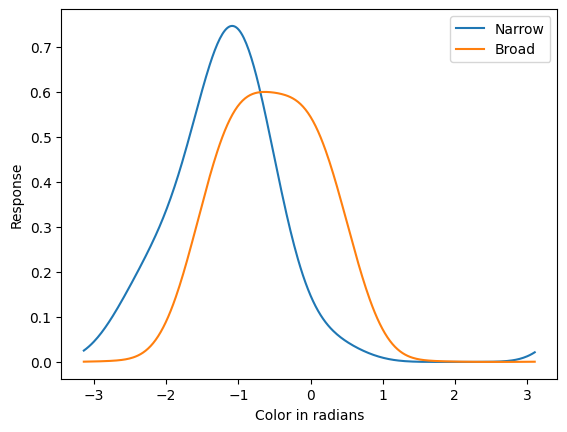

In [17]:
# To sample colors within a range on a circular space
def circunirand(x_cent, x_width, n=1, low=-np.pi, high=np.pi):
    """
    Generates n random numbers from a uniform range within a circular space.

    Args:
        x_cent: The center of the desired uniform range within the circular space.
        x_width: The width of the desired uniform range.
        low: The lower bound of the circular space (default: -π).
        high: The upper bound of the circular space (default: π).

    Returns:
        A NumPy array of n random numbers within the specified circular range,
        wrapping around if the range extends beyond the circular space boundaries.
    """

    # Calculate the actual lower and upper bounds, handling wrapping
    lower_bound = (x_cent - x_width / 2) 
    upper_bound = (x_cent + x_width / 2)

    # Generate random numbers within the adjusted bounds
    random_numbers = np.random.uniform(lower_bound, upper_bound,n)

    # Handle wrapping for values that went below the lower bound
    random_numbers[random_numbers < low] += (high - low)

    # Handle wrapping for values that went above the upper bound
    random_numbers[random_numbers > high] -= (high - low)

    return random_numbers

def make_channel_response(angular_space, channel_pref, channel_bases, df, n_dots=180):
    
    channel_response = np.zeros([len(df), len(channel_pref)])
    df = df.reset_index()
    for whTrl, trlN in df.iterrows():
        respN = []
        idx = np.argmin(abs(trlN["color_center"].iloc[0]-angular_space))
        if trlN["isTargetSNR"].iloc[0]==0:
            # Distractor
            
            # Record the response of each channel to the distractor color
            respN = channel_bases[:,idx]*n_dots
                      
        
        else:
            # Target
            
            if trlN["conditions"].iloc[0] == "Broad": width = 60*np.pi/180
            else: width = 20*np.pi/180
            
            clrN = trlN["color_center"].iloc[0]
            
            # Sample 180 colors from a uniform distribution around the color center
            clrN = circunirand(clrN-width/2,clrN+width/2,180)
            
            # Find the responses of each channel to each presented colors
            clrN = np.array([np.argmin(abs(np.around(angular_space,5)-x)) for x in clrN])
            
            # Sum the responses per channel
            respN = np.vstack([channel_bases[:,x] for x in clrN]).sum(axis=0)
        
        # make the sum equal to 1
        respN /= respN.sum()
        channel_response[whTrl,:] = respN.flatten()
    return(channel_response, channel_pref, channel_bases)

# Create the channel responses
ch_responses, _, _ = make_channel_response(stimulus_space, ch_preference, ch_bases, df_proc)

narrow_example_idx = np.where(np.all([df_proc.trial==201, df_proc.isTargetSNR],axis=0))[0]
broad_example_idx = np.where(np.all([df_proc.trial==270, df_proc.isTargetSNR],axis=0))[0]

plt.plot(stimulus_space, 
         (ch_responses[narrow_example_idx,:] @ ch_bases).T, label="Narrow")

plt.plot(stimulus_space, (ch_responses[broad_example_idx,:] @ ch_bases).T, label="Broad")

plt.legend()

plt.xlabel("Color in radians")
plt.ylabel("Response");

We can see that channel responses vary depending on the stimulus display by looking at two examples, one from a narrow target condition and the other from a broad target condition. The colors represent whether the channel response is associated with the target or the distractor stimulus.
You can observe that peak response to the broad target is much wider than that to the narrow target since the broad target stimulates a wider range.

Next we will create a training and testing groups to predict channel responses.

### Training the model

We will first train our model to solve for $\hat{W}$ in Eq. 2. To create the training and testing sets we will randomly assign half of the observtions to each group while making sure the samples are balanced across the experimental factors.

In [18]:
from itertools import product
def get_interaction_levels(df, conditions):
  """
  Finds every unique combination of levels across specified columns in a DataFrame.

  Args:
    df: pandas DataFrame.
    conditions: List of column names.

  Returns:
    A list of tuples, where each tuple represents a unique combination of levels.
  """

  unique_values = [df[col].unique() for col in conditions]
  return list(product(*unique_values))

def balanced_sample_by_columns(df, columns, n_samples_per_level=None, n_splits=1, replace=False, seed = None):
  """
  Samples the same number of observations per level of specified columns in a DataFrame
  and splits the sampled data into subgroups, ensuring each subgroup has the same
  number of trials per level.

  Args:
    df: pandas DataFrame.
    columns: List of column names to sample by.
    n_samples_per_level: The number of samples to take per level of each column.
                         If None (default), takes the maximum number possible
                         (minimum count of any level in any column).
    n_splits: The number of subgroups to split the data into. Default is 1.

  Returns:
    A list of pandas DataFrames, each representing a balanced subgroup.
  """
  
  if seed is not None: np.random.seed(seed)
  subgroups = [pd.DataFrame() for _ in range(n_splits)]  # Initialize subgroups
  
  interaction_levels = get_interaction_levels(df, columns)
  
  if n_samples_per_level is None:
    # Calculate the minimum count of any level in any column
    n_samples_per_level = min([np.sum(np.all([df[colN] == lvlN for colN, lvlN in zip(columns, lvls)], axis=0)) // 2 for lvls in interaction_levels])
    # n_samples_per_level = min(df[col].value_counts().min() // n_splits for col in columns)
    
    
  for lvls in interaction_levels:
    
    level_df = df.loc[np.all([df[colN] == lvlN for colN, lvlN in zip(columns, lvls)], axis=0)]
    sampled_level_df = level_df.sample(n=n_samples_per_level * n_splits, replace=replace)
    # Split the samples for this level into subgroups
    level_subgroups = [
          sampled_level_df.iloc[i::n_splits] for i in range(n_splits)
      ]
    # Concatenate to the corresponding subgroup DataFrames
    for i, subgroup in enumerate(subgroups):
        subgroups[i] = pd.concat([subgroup, level_subgroups[i]])
      

  return subgroups

df_train, df_test = balanced_sample_by_columns(df_proc.reset_index(), ["search_frequency", *conditions_to_balance], n_splits=2, seed = 1203)
(C_train, _, _), (C_test, _, _) = [make_channel_response(stimulus_space, ch_preference, ch_bases, dfN) for dfN in (df_train, df_test)]

Next we will estimate the weights using the following formula:
$$
\hat{W} = B_{train} \ast C^{T}_{train} \ast (C_{train} \ast C^{T}_{train})^{-1}\tag{2}
$$

In [19]:
# estimate W_hat
def estimate_weights(B, C):
    
    return B.T @ C @ np.linalg.inv(C.T @ C)

W_hat = estimate_weights(df_train.fft_amplitude.values, C_train)

And Eq. 3 to reconstruct the channel responses of the left-out set.
$$
\hat{C}_{test} = (\hat{W}^{T} \ast \hat{W})^{-1} \ast \hat{W}^{T} \ast B_{test}\tag{3}
$$


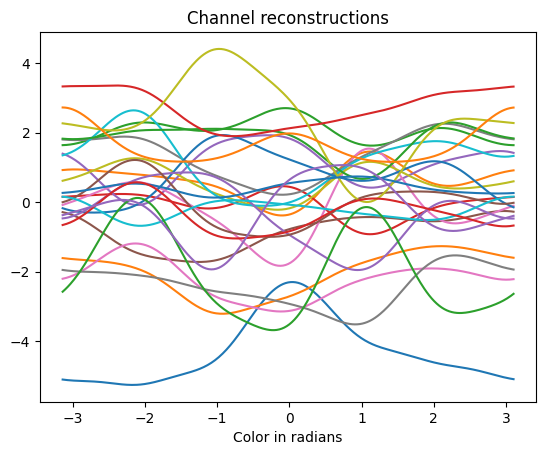

In [20]:
def reconstruct_channel_responses(W_hat, B, isMapRec2Bases=False):
    
    rec = (np.linalg.inv(W_hat.T @ W_hat) @ W_hat.T @ B.T).T
    
    # if True map 1-by-i reconstructions on the i-by-k channel bases
    # where i is the no of channels and k is the length of the stimulus space
    if isMapRec2Bases: return rec @ ch_bases
    else: return rec

C_hat = reconstruct_channel_responses(W_hat, df_test.fft_amplitude.values, isMapRec2Bases = True)
# Plot the first 5 trials
plt.plot(stimulus_space, C_hat.T[:,:25]);
plt.title("Channel reconstructions")
plt.xlabel("Color in radians");

Individual trials might look very noisy. Therefore, we will shift every trial to 0º color depending on the target color center and examine the average of shifted channel responses.

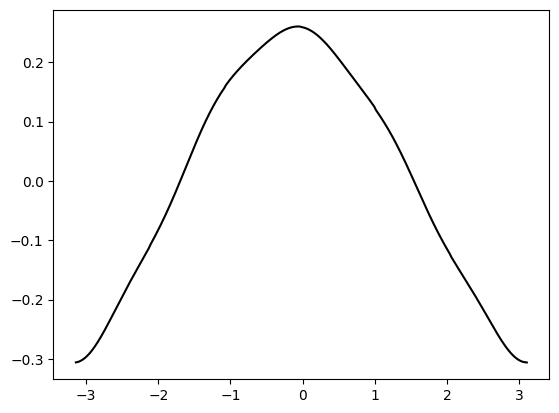

In [21]:
def center_shift_channel_responses(resp, stimulus_space,centers):
    
    shift_to_cent_by = [len(stimulus_space)//2 - np.argmin(np.abs(stimulus_space - centN)) for centN in centers]
    return np.vstack([np.roll(resp[n,:], shiftN) for n, shiftN in zip(range(resp.shape[0]), shift_to_cent_by)])
    
C_hat_cent = center_shift_channel_responses(C_hat, stimulus_space, df_test.color_center.values)
C_hat_cent = StandardScaler().fit_transform(C_hat_cent.T).T
plt.plot(stimulus_space, C_hat_cent.mean(axis=0).T, color = "black");

We can also split the trials per condition levels to examine if any differences jump out.

Text(0.5, 1.0, 'Broad')

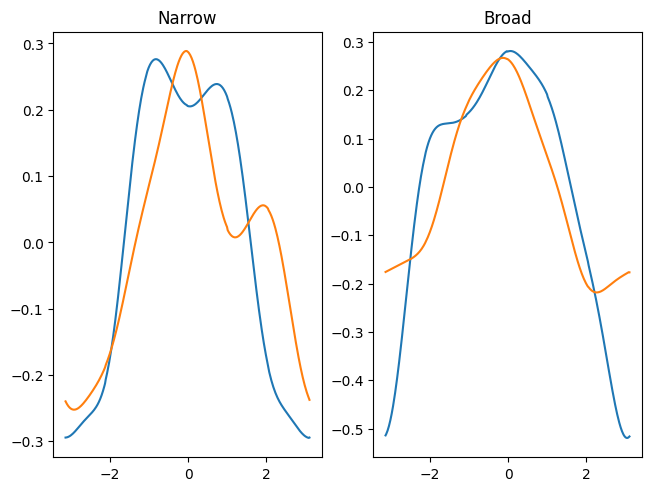

In [22]:
get_indices_per_level = lambda df, columns: {
    levels : np.all([df[colN] == levelN for colN, levelN in zip(columns, levels)], 
                    axis=0) for levels in get_interaction_levels(df, columns)
    }
cond_idx = get_indices_per_level(df_test, ["conditions", "isTargetSNR"])

fig, ax = plt.subplots(1, 2, layout="constrained")

ax[0].plot(stimulus_space, C_hat_cent[cond_idx[("Narrow", True)],:].mean(axis=0))
ax[0].plot(stimulus_space, C_hat_cent[cond_idx[("Narrow", False)],:].mean(axis=0))
ax[0].set_title("Narrow")

ax[1].plot(stimulus_space, C_hat_cent[cond_idx[("Broad", True)],:].mean(axis=0))
ax[1].plot(stimulus_space, C_hat_cent[cond_idx[("Broad", False)],:].mean(axis=0))
ax[1].set_title("Broad")

With fewer trials, the reconstructions gets less reliable. Often, trends might not arise in individual subject level. However, we can still improve our procedure by incorporating some data preprocesing methods that reduce linear dependence across our features (i.e., EEG channels). You can go to this (link)[NA] for a demo where we make use of several such methods (i.e., PCA, ICA, Ridge Regularization).

In the remaining of this tutorial, though we will evaluate the effectiveness of the Procrustes' transformation.

First, let's write a wrapper function that runs a full IEM procedure.

In [23]:
# Wrapper function for a full IEM procedure
def do_IEM(B_train, B_test, C_train,
           isCenter=False, isNormalize=False, centers = None):
  # a full IEM procedure
  
  W_hat = estimate_weights(B_train, C_train)
  C_hat = reconstruct_channel_responses(W_hat,B_test) @ ch_bases
  
  if isCenter:
    if centers is None:
      raise Warning("Skipping channel response centering. You need to supply centers argument")
    else:
      C_hat = center_shift_channel_responses(C_hat, stimulus_space, centers)
      
  if isNormalize: C_hat = StandardScaler().fit_transform(C_hat.T).T    
  
  return(C_hat)

## Evaluating the effectiveness of the Procrustes' transformation.

There are several methods to evaluate the results from an IEM procedure but we can start off with comparing the reconstructions by using different training and testing sets with aligned and original feature matrices as follows

1. Train and test within frequency
2. Train and test across frequencies
3. Train and test mixed frequencies

We will also create multiple random training and testing folds to minimize sampling errors.

Let's first select first 10 participants from the original dataset.

In [26]:
n_sub = 20
subs = np.arange(n_sub)
# Sub7 session is incomplete
subs[subs==7] = 16
subs = np.sort(subs)
df = process_fft_data(filepath='./data/trial_fft_and_snrs_per_channel.csv', 
                      participant_id=subs)
df

participant search_frequency trial conditions target_frequency  \
channels                                                                  
0                  0             7.50     0      Broad             7.50   
1                  0             7.50     1     Narrow             8.57   
2                  0             7.50     2     Narrow             8.57   
3                  0             7.50     3     Narrow             8.57   
4                  0             7.50     4      Broad             7.50   
...              ...              ...   ...        ...              ...   
14205             19             8.57   435     Narrow             8.57   
14206             19             8.57   436      Broad             8.57   
14207             19             8.57   437      Broad             7.50   
14208             19             8.57   438      Broad             8.57   
14209             19             8.57   439      Broad             8.57   

         color_center fft_amplitude                                ...  \
channels                         C3        C4       CP1       CP2  ...   
0               -2.09      0.499399  0.546773  0.562714  0.604932  ...   
1               -1.05      0.357291  0.373028  0.456085  0.307650  ...   
2               -1.05      0.660938  0.345281  0.760275  0.389766  ...   
3               -3.14      0.363675  0.439570  0.417856  0.495302  ...   
4                1.05      0.647300  0.373676  0.672685  0.409553  ...   
...               ...           ...       ...       ...       ...  ...   
14205           -3.14      0.489619  0.578482  0.332269  0.389034  ...   
14206            0.00      0.234847  0.322230  0.184842  0.328699  ...   
14207           -3.14      0.410854  0.560927  0.490434  0.495849  ...   
14208           -1.05      0.209463  0.329180  0.429979  0.289261  ...   
14209            0.00      0.519864  0.602618  0.841351  0.829207  ...   

                                                                      \
channels        P7        P8       PO3       PO4       PO7       PO8   
0         0.404071  0.428178  0.605752  0.732100  0.372680  0.699684   
1         0.148883  0.379842  0.397521  0.307947  0.327049  0.390432   
2         0.392349  0.686916  0.455414  0.619919  0.483795  0.875005   
3         0.414036  0.193632  0.258510  0.316053  0.463249  0.442197   
4         0.524707  0.535414  0.607081  0.566463  0.747163  0.787316   
...            ...       ...       ...       ...       ...       ...   
14205     0.494944  0.227135  0.197331  0.462187  0.484171  0.283754   
14206     0.501714  0.329623  0.359565  0.199516  0.560958  0.260793   
14207     0.477646  0.301714  0.279974  0.426003  0.687048  0.205284   
14208     0.820421  0.476885  0.584902  0.266142  0.775293  0.624813   
14209     0.486669  0.399746  0.353539  0.373839  0.482979  0.560306   

                                       isTargetSNR  
channels       POz        T7        T8              
0         0.692044  0.661937  0.480540        True  
1         0.231219  0.299008  0.465609       False  
2         0.351619  0.527308  0.145086       False  
3         0.325732  0.556266  0.278295       False  
4         0.484850  0.452091  0.337881        True  
...            ...       ...       ...         ...  
14205     0.288824  0.703037  0.683202        True  
14206     0.368551  0.257708  0.152474        True  
14207     0.626275  0.450556  0.263056       False  
14208     0.466709  0.346840  0.274513        True  
14209     0.542765  0.343778  0.432796        True  

[14210 rows x 37 columns]

In [27]:
# Initiate a dictionary to store average centred channel reconstructions per subject and fold
k_fold = 10
rec_mat = np.zeros([k_fold, len(stimulus_space)])
comparisons = ["Train7Test7", "Train7Test8", "Train8Test7", "Train8Test8", "TrainAllTestAll"]
conditions = get_interaction_levels(df, ["conditions", "isTargetSNR"])

# Save each average centered reconstruction per participant, transformation, 
# condition, and training/testing set type
C_hat = {
    f"Sub{whSub}": {
        transN: {
            condN: {compN: rec_mat.copy() 
                    for compN in comparisons}
            for condN in conditions}
         for transN in ["original", "aligned"]}
        
    for whSub in range(n_sub)}

for whSub, subN in enumerate(df.participant.unique()):
    
    
    dfN = df.loc[df.participant==subN]

    for k in range(k_fold):
        
        # Draw the aligned and original samples for the current fold
        df_orgN, mat1, mat2 = balance_and_align(dfN, conditions_to_balance, transform_by_column, isNormalize=True)
        df_orgN["fft_amplitude"] = StandardScaler().fit_transform(df_orgN["fft_amplitude"])
        df_algN = df_orgN.copy()
        df_algN["fft_amplitude"] = np.vstack([mat1, mat2])
        
        # To draw the same rows in samples for the original and aligned matrices
        seed = np.random.randint(10**4)
        
        # frequency indices
        is7 = df_orgN.search_frequency == min(stim_freqs)
        is8 = df_orgN.search_frequency == max(stim_freqs)
        
        # Train on 7, Test on 7
        ## Original
        
        # Split the samples to testing and training
        df_train_org7N, df_test_org7N = balanced_sample_by_columns(df_orgN[is7], conditions_to_balance, n_splits=2, seed=seed)     
        # Create channel responses based on displayed stimuli
        (C_train_org7N, _, _), (C_test_org7N, _, _) = [make_channel_response(stimulus_space, ch_preference, ch_bases, dfN) for dfN in (df_train_org7N, df_test_org7N)]
        # reconstruct the channel responses
        recN = do_IEM(
            df_train_org7N.fft_amplitude.values, df_test_org7N.fft_amplitude.values, 
            C_train_org7N, centers = df_test_org7N.color_center.values,
            isCenter=True, isNormalize=True
            )
        # Separate reconstructions by condition and save the average across trials
        cond_idx = get_indices_per_level(df_test_org7N, ["conditions", "isTargetSNR"])
        for condN, idxN in cond_idx.items():
            C_hat[f"Sub{whSub}"]["original"][condN]["Train7Test7"][k,:] = recN[idxN,:].mean(axis=0)
            
        # Hereon, the same steps are implemented but with 
        # the respective feature matrices and testing/training sets
        
        ## Aligned
        df_train_alg7N, df_test_alg7N = balanced_sample_by_columns(df_algN[is7], conditions_to_balance, n_splits=2, seed=seed)     
        (C_train_alg7N, _, _), (C_test_alg7N, _, _) = [make_channel_response(stimulus_space, ch_preference, ch_bases, dfN) for dfN in (df_train_alg7N, df_test_alg7N)]
        recN = do_IEM(
            df_train_alg7N.fft_amplitude.values, df_test_alg7N.fft_amplitude.values, 
            C_train_alg7N,  centers = df_test_alg7N.color_center.values,
            isCenter=True, isNormalize=True            
        )
        # trial indices are the same as the original
        for condN, idxN in cond_idx.items():
            C_hat[f"Sub{whSub}"]["aligned"][condN]["Train7Test7"][k,:] = recN[idxN,:].mean(axis=0)

        # Train on 8, Test on 8
        ## Original               
        df_train_org8N, df_test_org8N = balanced_sample_by_columns(df_orgN[is8], conditions_to_balance, n_splits=2, seed=seed)
        (C_train_org8N, _, _), (C_test_org8N, _, _) = [make_channel_response(stimulus_space, ch_preference, ch_bases, dfN) for dfN in (df_train_org8N, df_test_org8N)]
        recN = do_IEM(
            df_train_org8N.fft_amplitude.values, df_test_org8N.fft_amplitude.values,
            C_train_org8N,  centers = df_test_org8N.color_center.values,
            isCenter=True, isNormalize=True            
        )
        cond_idx = get_indices_per_level(df_test_org8N, ["conditions", "isTargetSNR"])
        for condN, idxN in cond_idx.items():
            C_hat[f"Sub{whSub}"]["original"][condN]["Train8Test8"][k,:] = recN[idxN,:].mean(axis=0)
            
        ## Aligned        
        df_train_alg8N, df_test_alg8N = balanced_sample_by_columns(df_algN[is8], conditions_to_balance, n_splits=2, seed=seed)
        (C_train_alg8N, _, _), (C_test_alg8N, _, _) = [make_channel_response(stimulus_space, ch_preference, ch_bases, dfN) for dfN in (df_train_alg8N, df_test_org8N)]
        recN = do_IEM(
            df_train_alg8N.fft_amplitude.values, df_test_alg8N.fft_amplitude.values,
            C_train_alg8N,  centers = df_test_alg8N.color_center.values,
            isCenter=True, isNormalize=True            
        )
        for condN, idxN in cond_idx.items():
            C_hat[f"Sub{whSub}"]["aligned"][condN]["Train8Test8"][k,:] = recN[idxN,:].mean(axis=0)
        
        # Train on 7/8 test on 8/7 (more trials!)
        df_org7N, df_org8N = df_orgN[is7], df_orgN[is8]
        df_alg7N, df_alg8N = df_algN[is7], df_algN[is8]
        (C_org7N, _, _), (C_org8N, _, _),  (C_alg7N, _, _),  (C_alg8N, _, _),  = [make_channel_response(stimulus_space, ch_preference, ch_bases, dfN) for dfN in (df_org7N, df_org8N, df_alg7N, df_alg8N)]
        ## Train on 7 Test on 8
        ### Original
        recN = do_IEM(
            df_org7N.fft_amplitude.values, df_org8N.fft_amplitude.values,
            C_org7N, centers = df_org8N.color_center.values,
            isCenter=True, isNormalize=True            
        )
        cond_idx = get_indices_per_level(df_org8N, ["conditions", "isTargetSNR"])
        for condN, idxN in cond_idx.items():
            C_hat[f"Sub{whSub}"]["original"][condN]["Train7Test8"][k,:] = recN[idxN,:].mean(axis=0)
        ### Aligned
        recN = do_IEM(
            df_alg7N.fft_amplitude.values, df_alg8N.fft_amplitude.values,
            C_alg7N,  centers = df_alg8N.color_center.values,
            isCenter=True, isNormalize=True            
        )
        for condN, idxN in cond_idx.items():
            C_hat[f"Sub{whSub}"]["aligned"][condN]["Train7Test8"][k,:] = recN[idxN,:].mean(axis=0)
        
        ## Train on 8 Test on 7
        ### Original
        recN = do_IEM(
            df_org8N.fft_amplitude.values, df_org7N.fft_amplitude.values, 
            C_org8N, centers = df_org7N.color_center.values,
            isCenter=True, isNormalize=True            
        )
        cond_idx = get_indices_per_level(df_org7N, ["conditions", "isTargetSNR"])
        for condN, idxN in cond_idx.items():
            C_hat[f"Sub{whSub}"]["original"][condN]["Train8Test7"][k,:] = recN[idxN,:].mean(axis=0)
        ### Aligned
        recN = do_IEM(
            df_alg8N.fft_amplitude.values, df_alg7N.fft_amplitude.values,
            C_alg8N,  centers = df_alg7N.color_center.values,
            isCenter=True, isNormalize=True            
        )
        for condN, idxN in cond_idx.items():
            C_hat[f"Sub{whSub}"]["aligned"][condN]["Train8Test7"][k,:] = recN[idxN,:].mean(axis=0)
        
        # Train and Test on Mixed
        ## Original
        df_train_orgN, df_test_orgN = balanced_sample_by_columns(df_orgN, ["search_frequency", *conditions_to_balance], n_splits=2, seed=seed)
        (C_train_orgN, _, _), (C_test_orgN, _, _) = [make_channel_response(stimulus_space, ch_preference, ch_bases, dfN) for dfN in (df_train_orgN, df_test_orgN)]
        recN = do_IEM(
            df_train_orgN.fft_amplitude.values, df_test_orgN.fft_amplitude.values,
            C_train_orgN, centers = df_test_orgN.color_center.values,
            isCenter=True, isNormalize=True            
        )
        cond_idx = get_indices_per_level(df_test_orgN, ["conditions", "isTargetSNR"])
        for condN, idxN in cond_idx.items():
            C_hat[f"Sub{whSub}"]["original"][condN]["TrainAllTestAll"][k,:] = recN[idxN,:].mean(axis=0)
        ## Aligned
        df_train_algN, df_test_algN = balanced_sample_by_columns(df_algN, ["search_frequency", *conditions_to_balance], n_splits=2, seed=seed)
        (C_train_algN, _, _), (C_test_algN, _, _) = [make_channel_response(stimulus_space, ch_preference, ch_bases, dfN) for dfN in (df_train_algN, df_test_algN)]
        recN = do_IEM(
            df_train_algN.fft_amplitude.values, df_test_algN.fft_amplitude.values,
            C_train_algN, centers = df_test_algN.color_center.values,
            isCenter=True, isNormalize=True      
        )
        for condN, idxN in cond_idx.items():
            C_hat[f"Sub{whSub}"]["aligned"][condN]["TrainAllTestAll"][k,:] = recN[idxN,:].mean(axis=0)
        
        print(f"\rSub{whSub+1} of {n_sub}\tFold{k+1} of {k_fold}", end="")


Sub18 of 20	Fold9 of 10

Below we will combine reconstructions from different training/testing sets according to whether their models were trained and tested 'Within', 'Across', or 'Mixed' frequencies.

We will also compute three summary statistics which will be informative about the quality of the reconstructions.
1. Fidelity: circular mean of the convolution with a cosine signal centered at 0º. It shows the deviation from the original stimulus center in radians.
2. Amplitude: difference between the peak amlitude and the baseline of reconstructions. It will be informative when we compare target (expected to be higher) versus distractor reconstructions.
3. Width: width of reconstructions where it reaches the half of the peak amplitude. This will be informative when we compare Narrow and broad targets since the latter should have wider distribution than the former.

In [28]:
# Combine corresponding recontructions under the same key
comparisons_comb = ["Within", "Across", "Mixed"]
from scipy.stats import circmean

compute_fidelity = lambda respN: circmean(respN * np.cos(stimulus_space),low=-np.pi,high=np.pi)
compute_amplitude = lambda recN: np.max(recN)-np.min(recN)
compute_width = lambda recN: stimulus_space[180+np.argmin(abs(recN[180:] - recN.max()/2))] - stimulus_space[np.argmin(abs(recN[:180] - recN.max()/2))]

C_hat_comb = {
    f"Sub{whSub}": {
        transN: {
            condN: {compN: rec_mat.copy() 
                    for compN in comparisons_comb}
            for condN in conditions}
         for transN in ["original", "aligned"]}
        
    for whSub in range(n_sub)}

stats_names = ["fidelity", "amplitude", "width"]
SummaryStats = {
    f"Sub{whSub}": {
        transN: {
            condN: {compN: {statN: [] for statN in stats_names}
                    for compN in comparisons_comb}
            for condN in conditions}
         for transN in ["original", "aligned"]}
        
    for whSub in range(n_sub)}

for whSub, subN in C_hat.items():
    
    for whTrans, transN in subN.items():
        
        for whRec, recN in transN.items():

        
            C_hat_comb[whSub][whTrans][whRec]["Within"] = np.vstack([recN["Train7Test7"], recN["Train8Test8"]])
            C_hat_comb[whSub][whTrans][whRec]["Across"] = np.vstack([recN["Train7Test8"], recN["Train8Test7"]])
            C_hat_comb[whSub][whTrans][whRec]["Mixed"] = recN["TrainAllTestAll"]
            
            for statsN, funcN in zip(stats_names, [compute_fidelity, compute_amplitude, compute_width]):
                
                for compN in comparisons_comb:
                    SummaryStats[whSub][whTrans][whRec][compN][statsN] = np.apply_along_axis(funcN, 
                                                                        arr=C_hat_comb[whSub][whTrans][whRec][compN],
                                                                        axis=1).mean()
                

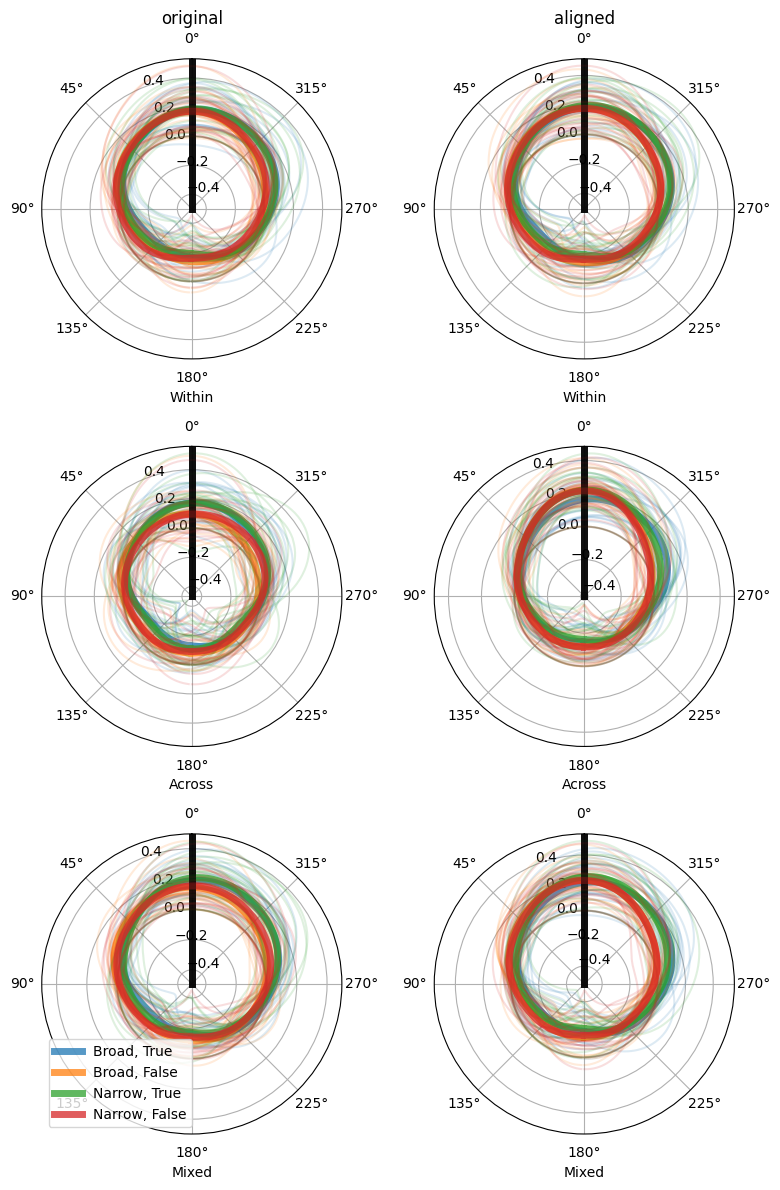

In [29]:
fig, ax = plt.subplots(len(comparisons_comb), 2, figsize = (8, 12), subplot_kw={'projection': 'polar'})

for whComp, compN in enumerate(comparisons_comb):
    
    for whTrans, transN in enumerate(["original", "aligned"]):
        
        ax[whComp, whTrans].set_xlabel(compN)
        for whCond, condN in enumerate(conditions):
    
            ax[0, whTrans].set_title(transN)
            respN =  np.zeros([n_sub,len(stimulus_space)])     
            for whSub in range(n_sub):
                respN[whSub,:] = C_hat_comb[f"Sub{whSub}"][transN][condN][compN].mean(axis=0)
                ax[whComp, whTrans].plot(stimulus_space, respN[whSub], 
                                         color = f"C{whCond}", alpha=.15)
                  
            ax[whComp, whTrans].plot(stimulus_space, respN.mean(axis=0), 
                                     color = f"C{whCond}", lw=5, alpha=.75, label = f"{condN[0]}, {condN[1]}")
            ax[whComp, whTrans].set_theta_zero_location("N")
            ax[whComp, whTrans].axvline(0, color='k', alpha=.5, lw=5)  
            
ax[-1,0].legend()
fig.tight_layout()

Each plot draws the centered and recronstructed channel responses collapsed across testing/training folds per participants. The colors indicate the conditions (i.e., target color range and target/distractor). Rows indicate whether the training and testing sets belong to data from the same SSVEP frequency (e.g., trained on 7 tested on 7 Hz; Within), different frequencies (e.g. trained on 7 tested on 8 Hz; Across) or mixed frequency samples (e.g., trained on 7 & 8, tested on 7 & 8 Hz; Mixed). Columns indicate whether the samples from different frequencies were aligned (Right) using the Procrustes transformation or not (Left). A successful reconstruction should be look bulging toward 0º (thick, black line).

First, you can observe in the first row that alignment did not change the reconstructions much when the model was trained and tested on the same frequency. However, when we focus on the second row (trained and tested on cross-frequency samples), you can observe the aligned reconstructions are much bulbier. When we look at the variance among the participant reconstructions (thin, transparent lines) you can observe that the aligned reconstructions vary much less across participants. The reduced variance can also be observed in the 3rd row with models trained and tested on mixed frequency samples.

To better quantify the improvement by alignment, we can also examine the summary statistics.

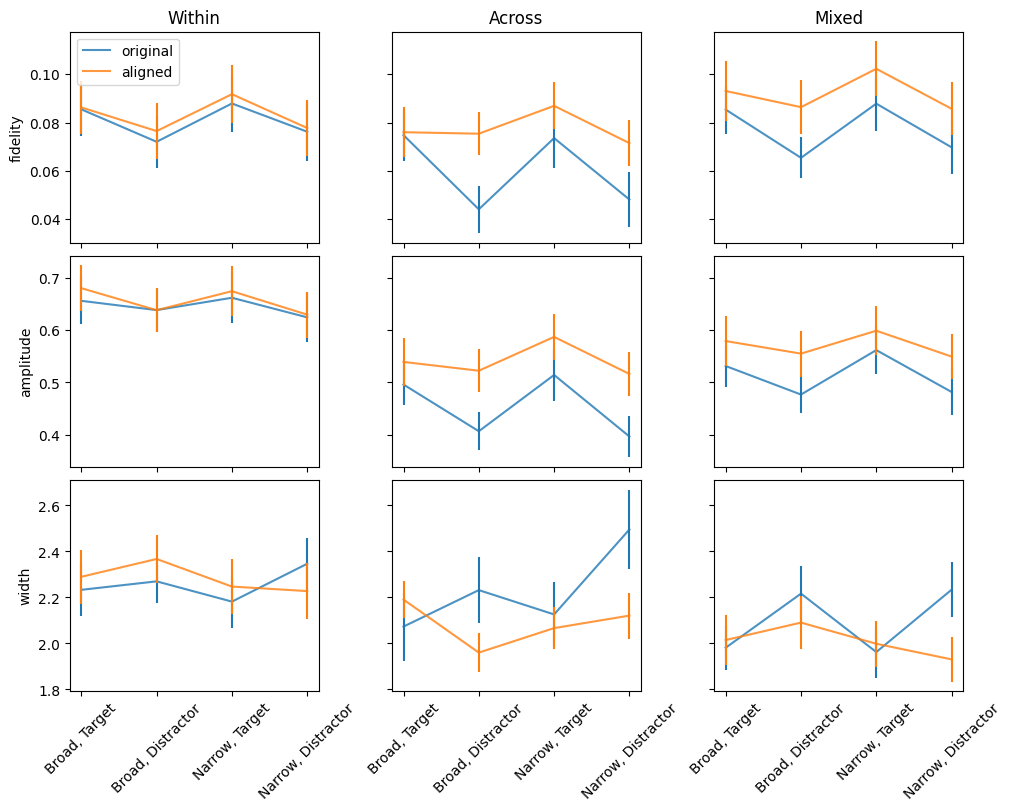

In [30]:
trans =["original", "aligned"]
fig, ax = plt.subplots(len(stats_names), len(comparisons_comb), layout = "constrained", figsize = (10, 8), sharey="row", sharex=True)

f = np.zeros([len(comparisons_comb), len(trans), len(stats_names), len(conditions), 2])
for whTrans, transN in enumerate(trans):
    
    for whComp, compN in enumerate(comparisons_comb):
        
        for whStats, statsN in enumerate(stats_names):
            
            for whCond, condN in enumerate(conditions):
        
                fN = np.hstack([SummaryStats[f"Sub{whSub}"][transN][condN][compN][statsN].mean() for whSub in range(n_sub)])
                f[whComp, whTrans, whStats, whCond, :] = [np.nanmean(fN), np.nanstd(fN)/np.sqrt(n_sub)]

cond_labels = [f"{condN[0]}, Target" if condN[1] else f"{condN[0]}, Distractor"  for condN in conditions]
for whComp, compN in enumerate(comparisons_comb):
    
    for whStats, statsN in enumerate(stats_names):
        
        for whTrans, transN in enumerate(trans):
        # for whCond, condN in enumerate(conditions):
            
            yN = f[whComp, whTrans, whStats, :, 0].T
            yerrN =  f[whComp, whTrans, whStats, :, 1].T
            ax[whStats, whComp].plot(cond_labels, yN, alpha = .8, color=f"C{whTrans}", label=transN)
            ax[whStats, whComp].errorbar(cond_labels, y = yN, yerr = yerrN, ls="", color=f"C{whTrans}")
            ax[0, whComp].set_title(compN)
            ax[whStats, 0].set_ylabel(statsN)
            ax[whStats, whComp].tick_params(axis='x', labelrotation=45)
            
ax[0,0].legend(loc="upper left");